# CS 579
<br>

## Clustering Words with K-Means

<br>


In [1]:
import pandas as pd
movies = pd.DataFrame([[123, ['horror', 'horror', 'romance', 'romance', 'romance']],
                       [456, ['romance']]], columns=['movieId', 'tokens'])
movies

,movieId,tokens
0,123,"[horror, horror, romance, romance, romance]"
1,456,[romance]


tfidf(i, d) := tf(i, d) / max_k tf(k, d) * log10(N/df(i))

- df(horror) = 1
- df(romance) = 2

- tf (horror, 123) = 2
- tfidf(horror, 123) = 2 / 3 * log10(2/1)

In [6]:
from scipy.sparse import csr_matrix
a = csr_matrix([1,2,3, 0, 0, 0, 5])
b = csr_matrix([4,5,6, 0, 0, 0, 0])
a.dot(b.T).sum()

32

In [9]:
from collections import Counter
import math
def featurize(movies):
    dfs = Counter()
    data = []
    rows = []
    cols = []
    for tokens in movies['tokens']:
        dfs.update(set(tokens))
    vocab = {v: i for i, v in enumerate(sorted(dfs))}
    N = len(movies)
    n_cols = len(vocab)
    vectors = []
    for tokens in movies.tokens:
        tfs = Counter(tokens)
        maxtf = max(tfs.values())
        rows = [0] * len(tfs)
        cols = [vocab[t] for t in tfs]
        data = [v / maxtf * math.log10(N / dfs[t])
                for t, v in tfs.items()]
        print('tf:', [v / maxtf for t, v in tfs.items()])
        print('idf_weight:', [math.log10(N / dfs[t]) for t, v in tfs.items()])

        vectors.append(csr_matrix((data, (rows, cols)), shape=(1, n_cols)))
        
    movies['features'] = vectors
    return movies, vocab

movies, vocab = featurize(movies)
movies

tf: [0.6666666666666666, 1.0]
idf_weight: [0.3010299956639812, 0.0]
tf: [1.0]
idf_weight: [0.0]


,movieId,tokens,features
0,123,"[horror, horror, romance, romance, romance]","(0, 0)\t0.200686663776\n (0, 1)\t0.0"
1,456,[romance],"(0, 1)\t0.0"


In [10]:
movies['features'][0].todense()

matrix([[ 0.20068666,  0.        ]])

# Motivation

Often, we want to know which features appear together.

- If you liked *Twilight* you might like *Nosferatu*.
- "happy" is a synonym of "glad."

Can be used to summarize a large collection of messages.

We'll use k-means to cluster together related words from Twitter.

**Caution:** This uses live Twitter data, which often contains profanity.

In [11]:
# Get some tweets containing the word 'i'.

import os
from TwitterAPI import TwitterAPI

# Read Twitter credentials from environmental variables.
api = TwitterAPI(os.environ.get('TW_CONSUMER_KEY'),
                 os.environ.get('TW_CONSUMER_SECRET'),
                 os.environ.get('TW_ACCESS_TOKEN'),
                 os.environ.get('TW_ACCESS_TOKEN_SECRET'))

# Collect 10000 tweets.
tweets = []
while True: 
    r = api.request('statuses/filter', {'track':'i',
                                        'language':'en'})
    if r.status_code != 200: # error
        break
    else:
        for item in r.get_iterator():
            tweets.append(item)
            if len(tweets) > 10000:
                break
            elif len(tweets) % 100 == 0:
                print(len(tweets))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [12]:
print(len(tweets))

10002


In [70]:
# Each tweet is a Python dict.
print('text', tweets[0]['text'])
print('description:', tweets[0]['user']['description'])
print('name:', tweets[0]['user']['name'])
print('location:', tweets[0]['user']['location'])

text RT @unheroicly: i love this song https://t.co/2pS8yLKvIQ
description: uh
name: morg
location: south wales x


In [71]:
tweets = [t for t in tweets if 'text' in t]

In [72]:
len(tweets)

9235

In [73]:
# Tokenize each tweet text.
import re
tokens = []
for tweet in tweets:
    text = tweet['text'].lower()
    text = re.sub('@\S+', ' ', text)  # Remove mentions.
    text = re.sub('http\S+', ' ', text)  # Remove urls.
    tokens.append(re.findall('[A-Za-z]+', text)) # Retain words.
tokens[0]

['rt', 'i', 'love', 'this', 'song']

In [74]:
# Count words.
from collections import Counter

word_counts = Counter()
for tweet in tokens:
    word_counts.update(tweet)

In [75]:
# Inspect word counts.
import math

print(len(word_counts), 'unique terms')
word_counts.most_common(10)

12139 unique terms


[('i', 10791),
 ('rt', 5155),
 ('the', 3714),
 ('to', 3344),
 ('a', 3147),
 ('and', 2377),
 ('you', 2253),
 ('my', 1960),
 ('m', 1825),
 ('of', 1721)]

In [76]:
# Retain in vocabulary words occurring more than twice.
vocab = set([w for w, c in word_counts.items() if c > 2])
print('%d words occur at least three times.' % len(vocab))

3748 words occur at least three times.


In [77]:
# Prune tokens.
newtoks = []
for i, tweet in enumerate(tokens):
    newtok = [token for token in tweet if token in vocab]
    if len(newtok) > 0:
        newtoks.append(newtok)
tokens = newtoks

In [82]:
# A sample pruned tweet.
tokens[0]

['rt', 'i', 'love', 'this', 'song']

In [85]:
import numpy as np
def get_contexts(tweet, i, window):
    """
    Get the context features for token at position i
    in this tweet, using the given window size.
    """
    features = []
    for j in range(np.amax([0, i-window]), i):
        features.append(tweet[j] + "@" + str(j-i))
    for j in range(i+1, min(i + window + 1, len(tweet))):
        features.append(tweet[j] + "@" + str(j-i))
    return features

get_contexts(tokens[0], i=3, window=2)

['i@-2', 'love@-1', 'song@1']

In [86]:
# For each term, create a context vector, indicating how often
# each word occurs to the left or right of it.
from collections import defaultdict
import numpy as np

# dict from term to context vector.
contexts = defaultdict(lambda: Counter())
window = 2
for tweet in tokens:
    for i, token in enumerate(tweet):
        features = get_contexts(tweet, i, window)
        contexts[token].update(features)
        # Optionally: ignore word order
        # contexts[token].update(tweet[:i] + tweet[i+1:])


In [87]:
contexts['i'].most_common(20)

[('rt@-1', 1757),
 ('m@1', 1756),
 ('t@2', 764),
 ('a@2', 519),
 ('to@2', 462),
 ('rt@-2', 425),
 ('and@-1', 422),
 ('can@1', 395),
 ('have@1', 378),
 ('just@1', 366),
 ('don@1', 345),
 ('love@1', 344),
 ('ve@1', 322),
 ('when@-1', 306),
 ('was@1', 304),
 ('am@1', 293),
 ('you@2', 289),
 ('the@2', 268),
 ('ll@1', 267),
 ('want@1', 230)]

In [88]:
# Compute the number of different contexts each term appears in.
tweet_freq = Counter()
for context in contexts.values():
    tweet_freq.update(context)
tweet_freq.most_common(5)

[('i@-1', 10635),
 ('i@-2', 10263),
 ('i@1', 8954),
 ('i@2', 6772),
 ('rt@-1', 5127)]

In [89]:
Counter(tweet_freq.values())

Counter({1: 224,
         2: 678,
         3: 3202,
         4: 1811,
         5: 1258,
         6: 1024,
         7: 676,
         8: 561,
         9: 482,
         10: 328,
         11: 279,
         12: 243,
         13: 224,
         14: 197,
         15: 181,
         16: 161,
         17: 146,
         18: 142,
         19: 156,
         20: 121,
         21: 100,
         22: 82,
         23: 82,
         24: 60,
         25: 67,
         26: 83,
         27: 64,
         28: 53,
         29: 79,
         30: 53,
         31: 49,
         32: 48,
         33: 38,
         34: 31,
         35: 42,
         36: 37,
         37: 40,
         38: 50,
         39: 36,
         40: 26,
         41: 39,
         42: 32,
         43: 45,
         44: 25,
         45: 28,
         46: 20,
         47: 22,
         48: 24,
         49: 28,
         50: 38,
         51: 15,
         52: 15,
         53: 22,
         54: 11,
         55: 26,
         56: 20,
         57: 24,
         58: 30

In [91]:
# Transform each context vector to be term freq / tweet frequency. 
# Also then normalize by length.
for term, context in contexts.items():
    for term2, frequency in context.items():
        context[term2] = frequency / (1. + math.log(tweet_freq[term2]))
    length = math.sqrt(sum([v*v for v in context.values()]))
    for term2, frequency in context.items():
        context[term2] = 1. * frequency / length
    
contexts['i'].most_common(5)

[('m@1', 0.5348416998626828),
 ('rt@-1', 0.47718655488402345),
 ('t@2', 0.23745836508511597),
 ('a@2', 0.14916223680739002),
 ('can@1', 0.13601059357820566)]

In [92]:
contexts['school'].most_common(10)

[('high@-1', 0.38800295111622285),
 ('learn@-2', 0.3529463081704446),
 ('at@-1', 0.2667839867762236),
 ('in@-1', 0.2086612877584478),
 ('middle@-1', 0.1764731540852223),
 ('and@1', 0.16832763251562577),
 ('bus@1', 0.15374049576328533),
 ('my@-1', 0.1436004814848667),
 ('in@-2', 0.12052115264917021),
 ('today@1', 0.11960096270951157)]

In [95]:
contexts['love'].most_common(10)

[('i@-1', 0.8141403726522269),
 ('you@1', 0.3105791369815186),
 ('rt@-2', 0.2013138503585514),
 ('i@-2', 0.1258707204596764),
 ('mommy@2', 0.11710090003630982),
 ('it@1', 0.11359980067546291),
 ('this@1', 0.09205216940200686),
 ('smothered@-2', 0.08371089223507543),
 ('aff@2', 0.08371089223507543),
 ('affection@2', 0.08244650211913902)]

In [96]:
contexts['hate'].most_common(10)

[('i@-1', 0.6463444525203702),
 ('crime@1', 0.44433510232223705),
 ('amp@-2', 0.2850941944330984),
 ('a@-1', 0.20805648100428276),
 ('when@1', 0.20063109214120775),
 ('rt@-2', 0.18012479341462465),
 ('letting@1', 0.13792321943635005),
 ('close@2', 0.11006059894303455),
 ('people@2', 0.10481011273849687),
 ('i@-2', 0.09919652344126183)]

At this point we have a list of dictionaries, one per term, indicating the terms that co-occur (weighted by inverse tweet frequency).

Next, we have to cluster these vectors. To do this, we'll need to be able to compute the euclidean distance between two vectors.

In [29]:
# n.b. This is not efficient!
def distance(c1, c2):
    if len(c1.keys()) == 0 or len(c2.keys()) == 0:
        return 1e9
    keys = set(c1.keys()) | set(c2.keys())
    distance = 0.
    for k in keys:
        distance += (c1[k] - c2[k]) ** 2
    return math.sqrt(distance)

print(distance({'hi':10, 'bye': 5}, {'hi': 9, 'bye': 4}))
print(distance({'hi':10, 'bye': 5}, {'hi': 8, 'bye': 4}))

1.4142135623730951
2.23606797749979


In [97]:
def find_closest(term, n=5):
    terms = np.array(list(contexts.keys()))
    context = contexts[term]
    distances = []
    for term2, context2 in contexts.items():
        distances.append(distance(context, context2))
    return terms[np.argsort(distances)][:n]

find_closest('love', n=10)

array(['love', 'hope', 'miss', 'm', 'am', 'll', 'guess', 'think', 've',
       'just'],
      dtype='<U21')

In [98]:
nz_contexts = [t for t, context in contexts.items()
               if len(context) > 1]
contexts = dict([(term, contexts[term]) for term in nz_contexts])
print(len(nz_contexts), 'nonzero contexts')

3748 nonzero contexts


In [99]:
# e..g., what are three context features for the term "rt"?
print(list(contexts.keys())[0])
print(list(list(contexts.values())[0].items())[:3])

rt
[('i@1', 0.8766515168186277), ('love@2', 0.05575788542455453), ('ng@1', 0.002401254444845591)]


In [100]:
# Transform context dicts to a sparse vector
# for sklearn.
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X = vec.fit_transform(contexts.values())
names = np.array(vec.get_feature_names())
print(names[:10])
print(X[0])

['a@-1' 'a@-2' 'a@1' 'a@2' 'aang@-1' 'aang@-2' 'aang@1' 'aang@2' 'able@-1'
 'able@-2']
  (0, 0)	0.00167789789884
  (0, 1)	0.00056450349112
  (0, 2)	0.0256339003198
  (0, 3)	0.0279423879128
  (0, 15)	0.00288518525991
  (0, 18)	0.00240125444485
  (0, 22)	0.00129532661652
  (0, 23)	0.00131464169454
  (0, 47)	0.00193118298089
  (0, 89)	0.00297629299096
  (0, 109)	0.00152586593359
  (0, 124)	0.00193118298089
  (0, 140)	0.014517576632
  (0, 153)	0.00415434682369
  (0, 212)	0.00180506313016
  (0, 216)	0.00157614892676
  (0, 237)	0.00720376333454
  (0, 248)	0.021137681212
  (0, 249)	0.00250422808562
  (0, 261)	0.00276008337091
  (0, 269)	0.00163643375527
  (0, 273)	0.00240125444485
  (0, 293)	0.00482737297348
  (0, 296)	0.00111332317847
  (0, 297)	0.00723681736636
  :	:
  (0, 14691)	0.0145692909941
  (0, 14692)	0.00388597984957
  (0, 14694)	0.000824494789694
  (0, 14695)	0.000789303153438
  (0, 14696)	0.00474611999356
  (0, 14699)	0.00928543660684
  (0, 14700)	0.00601191435705
  (0, 14703)	0.0

In [102]:
# Which row of X is the word "love"?
love_idx = list(contexts.keys()).index('love')
print(love_idx)
# What are the context feature values for love?
print(X[love_idx])
# Print a highly ranking feature.
print(names[14743])

2
  (0, 0)	0.00809444377632
  (0, 1)	0.00544650753013
  (0, 2)	0.0134415188201
  (0, 3)	0.00808790885641
  (0, 15)	0.00347964704628
  (0, 20)	0.00608408807693
  (0, 123)	0.0115840297016
  (0, 138)	0.00439402619225
  (0, 139)	0.0088767179772
  (0, 187)	0.00931633091108
  (0, 218)	0.0837108922351
  (0, 226)	0.0824465021191
  (0, 251)	0.00870790888402
  (0, 379)	0.00659262515803
  (0, 380)	0.0162872109942
  (0, 381)	0.0131344058608
  (0, 404)	0.00510593684227
  (0, 423)	0.00608408807693
  (0, 442)	0.0122745793276
  (0, 451)	0.00712287919769
  (0, 488)	0.0070137124198
  (0, 490)	0.0104771017539
  (0, 491)	0.0104887974929
  (0, 500)	0.00556011047179
  (0, 501)	0.0531565919884
  :	:
  (0, 14555)	0.00945352917138
  (0, 14590)	0.0216941289941
  (0, 14591)	0.00364104889952
  (0, 14599)	0.010607739342
  (0, 14612)	0.00681927978395
  (0, 14667)	0.00435282518242
  (0, 14668)	0.00439402619225
  (0, 14671)	0.0146734160731
  (0, 14672)	0.00989831971767
  (0, 14675)	0.00616320526507
  (0, 14690)	0.004

In [103]:
# Let's cluster!
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
num_clusters = 20
kmeans = KMeans(num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [104]:
# Let's print out the top features for each mean vector.
# This is swamped by common terms
for i in range(num_clusters):
    print(i, ' '.join(names[np.argsort(kmeans.cluster_centers_[i])[::-1][:5]]))

0 it@2 cloud@-2 make@1 liberals@-1 guard@-2
1 i@-2 m@-1 i@2 i@1 m@-2
2 a@-2 i@1 i@2 the@-2 a@-1
3 and@1 i@2 i@-2 to@-2 a@-1
4 i@-1 rt@-2 i@-2 a@1 to@1
5 of@1 the@-1 the@2 the@-2 a@-1
6 you@1 me@1 i@-2 rt@-2 i@2
7 the@-1 in@-2 i@2 on@-2 and@1
8 i@1 rt@-1 m@2 i@2 i@-2
9 in@1 the@2 i@-2 a@2 a@-1
10 a@-1 the@-1 i@2 i@1 of@1
11 my@-1 and@1 a@-1 i@2 i@1
12 the@-1 of@-2 i@1 i@2 of@-1
13 the@1 i@-2 my@1 i@2 a@1
14 rt@-1 i@1 the@-2 i@-2 rt@-2
15 t@-1 don@-2 can@-2 i@-2 to@-1
16 to@1 i@-2 be@2 i@-1 m@-1
17 t@1 i@-1 you@-1 rt@-2 even@2
18 an@-1 the@-1 i@1 i@2 to@2
19 to@-1 i@-2 i@-1 me@1 i@2


In [68]:
# .transform will compute the distance from each context to each cluster.
distances = kmeans.transform(X)
# e.g., what is the distance from the word "love" to each cluster?
print('distance from term "love" to each cluster:')
print(distances[love_idx])
# what is the closest cluster for the word "love"?
print('closest cluster to "love":')
print(np.argmin(distances[love_idx]))

distance from term "love" to each cluster:
[ 1.00606603  1.01782013  0.97889608  1.05252756  0.99111308  0.99801906
  1.00980453  0.61473522  0.95239746  0.9609487   1.02707764  0.99946716
  1.02367633  1.04759488  0.99433607  1.07227539  0.97752083  1.00250763
  0.9760815   0.98537512]
closest cluster to "love":
7


In [105]:
# Finally, we'll print the words that are closest
# to the mean of each cluster.
terms = np.array(list(contexts.keys()))
for i in range(distances.shape[1]):
    print(i, ' '.join(terms[np.argsort(distances[:,i])[1:10]]), '\n')

0 germany august the progress al awe glasgow trouble bed 

1 surname guests mouth sn avi name blog pl thoughts 

2 and the me you this but my what a 

3 out proud kind violations lots rest tired list type 

4 verified occasion rts hilarious dies mommy whore yesterday senses 

5 going supposed listening wanted able listen want tried used 

6 yeah when but and pressplay omg wow if hello 

7 am love ll miss just hope d guess ve 

8 on with for told made from at of is 

9 be get win go watch take do make study 

10 lot student few pedophile playlist couple child video joke 

11 crime bop gig deal whe kicked fan time weird 

12 heart family own dad room degree phone friend husband 

13 holidays bathroom best world roomba most first streets worst 

14 leak stepped homelessness live girl stuck bell knives log 

15 didn haven wouldn won wasn couldn can ain shouldn 

16 products person good verified kelley why what fr neighbor 

17 she paige mysecrethope there fox semester it brutus he 

18 not

Clearly, interpreting these results requires a bit of investigation.

As the number of tweets increases, we expect these clusters to become more coherent.

**How does error decrease with number of cluster?**

In [49]:
kmeans.score(X)

-3438.1336404513354

k=5 score=3554.24
k=10 score=3490.37
k=20 score=3439.58
k=50 score=3350.42
k=100 score=3268.95


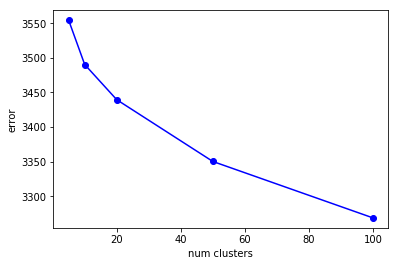

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
num_cluster_options = [5,10,20,50,100]

for num_clusters in num_cluster_options:
    kmeans = KMeans(num_clusters, n_init=10, max_iter=10)
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('k=%d score=%g' % (num_clusters, score))
    
plt.figure()
plt.plot(num_cluster_options, scores, 'bo-')
plt.xlabel('num clusters')
plt.ylabel('error')
plt.show()

** How does error vary by initalization? **

score=3467.15
score=3447.12
score=3447.76
score=3469.75
score=3450.49
score=3449.89
score=3437.55
score=3451.28
score=3436.78
score=3438.89


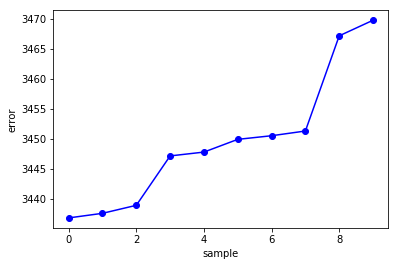

In [51]:
scores = []
for i in range(10):
    kmeans = KMeans(20, n_init=1, max_iter=100, init='random')
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('score=%g' % (score))
     
    
plt.figure()
plt.plot(range(10), sorted(scores), 'bo-')
plt.xlabel('sample')
plt.ylabel('error')
plt.show()